# Import all necessary packages

In [198]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
import json
from Functions import processing
import pandas as pd
import xlsxwriter


Load npy data

In [199]:
npy_file_name = r"C:\Users\admin\Documents\easy-on-the-eyes\Data\P010\npys\sub-P010_ses-S001_task-T1_run-001_eeg.npy"

eeg_epochs= np.load(npy_file_name)

isolate settings from json


In [200]:
json_file_name = r"C:\Users\admin\Documents\easy-on-the-eyes\Data\P010\jsons\sub-P010_ses-S001_task-T1_run-001_eeg.json"

with open(json_file_name, "r") as file_object:
        settings = json.load(file_object)

settings.keys()

eeg_fs = settings["eeg_srate"]
epoch_labels = settings["labels"]
dict_of_freqs = settings["freqs"]
dict_of_stimuli = settings["stimuli"]
nchans = len(settings["ch_names"])
ch_names = settings["ch_names"]


# Compute the power spectral density of each epoch


In [201]:
# PSD settings
window_size = 4 # Length of window for PSD [sec]

# for e,epoch in enumerate(eeg_epochs):
[eeg_f, eeg_pxx] = signal.welch(eeg_epochs, eeg_fs, nperseg=window_size*eeg_fs)

# Visualize PSDs

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
C:\Users\admin\AppData\Local\Temp\ipykernel_12432\2315686022.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax[0,0].set_ylabel("PXX [$\mu$V$^2$/Hz]")
C:\Users\admin\AppData\Local\Temp\ipykernel_12432\2315686022.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax[1,0].set_ylabel("PXX [$\mu$V$^2$/Hz]")


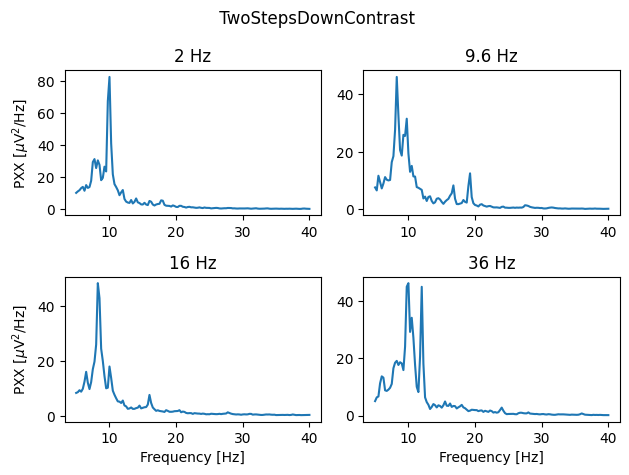

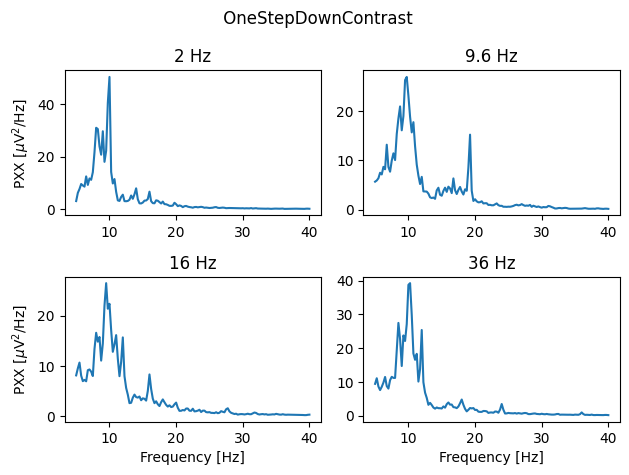

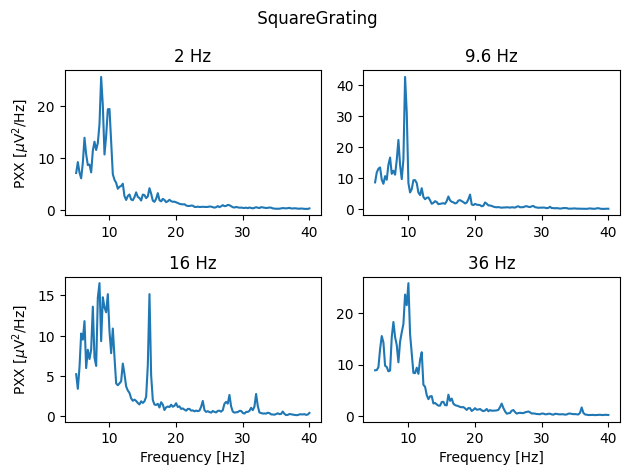

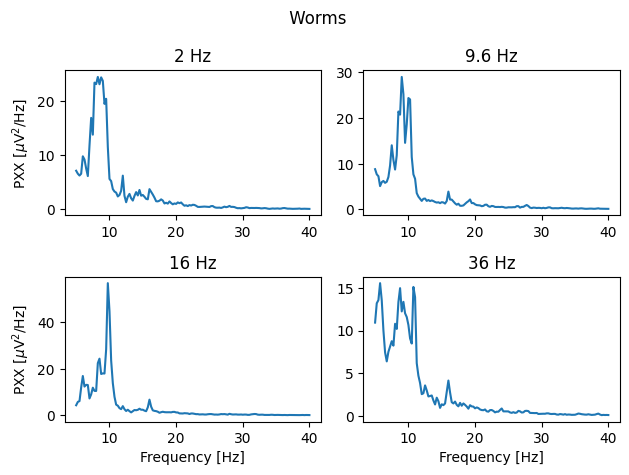

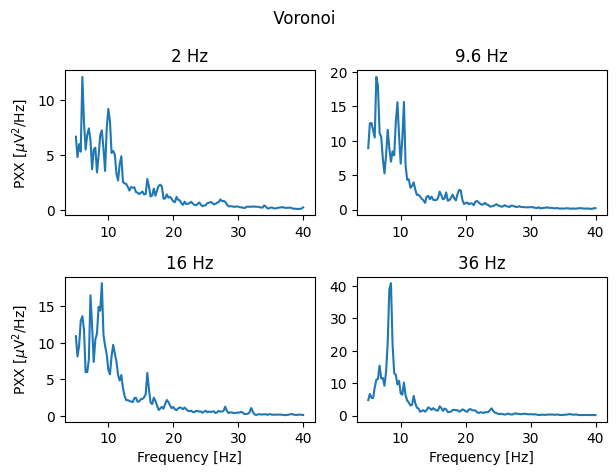

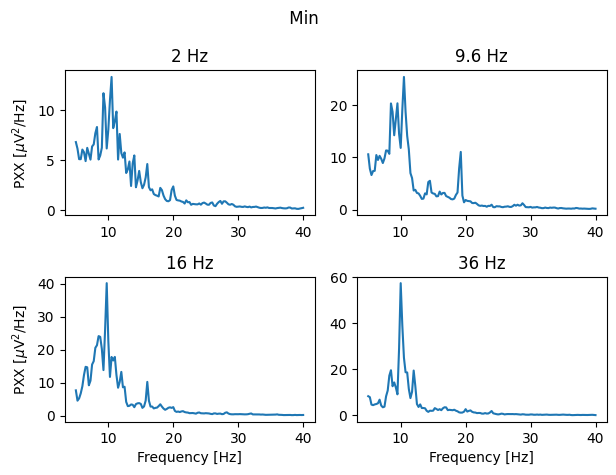

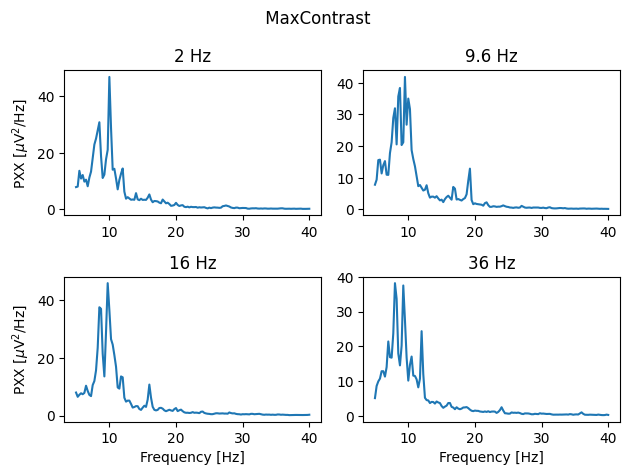

In [202]:
# Plot settings
f_limits = [5, 40]  # Frequency limits for the plots [min, max][Hz]

plot_psd = True # Enable to see plots

if plot_psd:
    for s, stim in dict_of_stimuli.items():
        fig, ax = plt.subplots(2,2)
        fig.suptitle(dict_of_stimuli[str(s)])

        for f, freq in dict_of_freqs.items():
            fmask = (eeg_f>=f_limits[0]) & (eeg_f<=f_limits[1])
            temp_freq = eeg_f[fmask]

            temp_mean = np.mean(eeg_pxx[int(s), int(f), :, :], axis=0)[fmask]
            temp_sd = np.std(eeg_pxx[int(s), int(f), :, :], axis=0)[fmask]

            row = int(f) // 2
            col = int(f) % 2
            ax[row, col].plot(temp_freq, temp_mean, '-')
            ax[row, col].set_title(f"{dict_of_freqs[f]} Hz")
            
        
        ax[0,0].set_ylabel("PXX [$\mu$V$^2$/Hz]")
        ax[1,0].set_ylabel("PXX [$\mu$V$^2$/Hz]")
        ax[1,0].set_xlabel("Frequency [Hz]")
        ax[1,1].set_xlabel("Frequency [Hz]")
        plt.tight_layout()


# Compute SNR

Compute modified SNR as described in [Norcia et al., 2015.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4581566/)

In [203]:
# Settings
noise_band = 0.5    # Single sided noise band [Hz]
nharms = 2          # Number of harmonics use [n]
db_out = True       # Boolean to get output in dB

# Preallocate variables
snr_np = np.zeros([
    len(dict_of_stimuli),
    len(dict_of_freqs),
    nchans
    ])

for s,stimuli in dict_of_stimuli.items():
    for f,freq in dict_of_freqs.items():
            snr_np[int(s),int(f),:] = processing.ssvep_snr(
                f=eeg_f,
                pxx=eeg_pxx[int(s),int(f),:,:],
                stim_freq=float(freq),
                noise_band=noise_band,
                nharms=nharms,
                db_out=db_out
                )


## Export SNR

Can only use this if the file contains all 7 stimuli
- hardcoded work arounds (this is so gross)

In [204]:
xlsx_file_name = npy_file_name.split("\\")[-1].split(".")[0]
path = r"C:\Users\admin\Documents\easy-on-the-eyes\Data"

if len(dict_of_stimuli.items()) == 7:
    stim_0_snr = snr_np[0,:,:]
    stim_1_snr = snr_np[1,:,:]
    stim_2_snr = snr_np[2,:,:]
    stim_3_snr = snr_np[3,:,:]
    stim_4_snr = snr_np[4,:,:]
    stim_5_snr = snr_np[5,:,:]
    stim_6_snr = snr_np[6,:,:]

    stim_0_result = pd.DataFrame(stim_0_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_1_result = pd.DataFrame(stim_1_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_2_result = pd.DataFrame(stim_2_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_3_result = pd.DataFrame(stim_3_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_4_result = pd.DataFrame(stim_4_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_5_result = pd.DataFrame(stim_5_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_6_result = pd.DataFrame(stim_6_snr, index= dict_of_freqs.values(), columns=ch_names)
    stims = pd.DataFrame(dict_of_stimuli.items())

    with pd.ExcelWriter(f"{path}\P010\snr\{xlsx_file_name}.xlsx", engine='xlsxwriter') as writer:
        stims.to_excel(writer, sheet_name = 'testSheetJ', startrow = 0, startcol= 0)
        stim_0_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims), startcol=0)
        stim_1_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+3, startcol=0)
        stim_2_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result)+6, startcol=0)
        stim_3_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result) + len(stim_2_result) +9, startcol=0)
        stim_4_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result) + len(stim_2_result) + len(stim_3_result) + 12, startcol=0)
        stim_5_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result) + len(stim_2_result) + len(stim_3_result) + len(stim_4_result) + 15, startcol=0)
        stim_6_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result) + len(stim_2_result) + len(stim_3_result) + len(stim_4_result) + len(stim_5_result) + 18, startcol=0)

if len(dict_of_stimuli.items()) == 6:
    stim_0_snr = snr_np[0,:,:]
    stim_1_snr = snr_np[1,:,:]
    stim_2_snr = snr_np[2,:,:]
    stim_3_snr = snr_np[3,:,:]
    stim_4_snr = snr_np[4,:,:]
    stim_5_snr = snr_np[5,:,:]

    stim_0_result = pd.DataFrame(stim_0_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_1_result = pd.DataFrame(stim_1_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_2_result = pd.DataFrame(stim_2_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_3_result = pd.DataFrame(stim_3_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_4_result = pd.DataFrame(stim_4_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_5_result = pd.DataFrame(stim_5_snr, index= dict_of_freqs.values(), columns=ch_names)
    stims = pd.DataFrame(dict_of_stimuli.items())

    with pd.ExcelWriter(f"{path}\P010\snr\{xlsx_file_name}.xlsx", engine='xlsxwriter') as writer:
        stims.to_excel(writer, sheet_name = 'testSheetJ', startrow = 0, startcol= 0)
        stim_0_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims), startcol=0)
        stim_1_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+3, startcol=0)
        stim_2_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result)+6, startcol=0)
        stim_3_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result) + len(stim_2_result) +9, startcol=0)
        stim_4_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result) + len(stim_2_result) + len(stim_3_result) + 12, startcol=0)
        stim_5_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result) + len(stim_2_result) + len(stim_3_result) + len(stim_4_result) + 15, startcol=0)

if len(dict_of_stimuli.items()) == 5:
    stim_0_snr = snr_np[0,:,:]
    stim_1_snr = snr_np[1,:,:]
    stim_2_snr = snr_np[2,:,:]
    stim_3_snr = snr_np[3,:,:]
    stim_4_snr = snr_np[4,:,:]

    stim_0_result = pd.DataFrame(stim_0_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_1_result = pd.DataFrame(stim_1_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_2_result = pd.DataFrame(stim_2_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_3_result = pd.DataFrame(stim_3_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_4_result = pd.DataFrame(stim_4_snr, index= dict_of_freqs.values(), columns=ch_names)
    stims = pd.DataFrame(dict_of_stimuli.items())

    with pd.ExcelWriter(f"{path}\P010\snr\{xlsx_file_name}.xlsx", engine='xlsxwriter') as writer:
        stims.to_excel(writer, sheet_name = 'testSheetJ', startrow = 0, startcol= 0)
        stim_0_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims), startcol=0)
        stim_1_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+3, startcol=0)
        stim_2_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result)+6, startcol=0)
        stim_3_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result) + len(stim_2_result) +9, startcol=0)
        stim_4_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result) + len(stim_2_result) + len(stim_3_result) + 12, startcol=0)

if len(dict_of_stimuli.items()) == 4:
    stim_0_snr = snr_np[0,:,:]
    stim_1_snr = snr_np[1,:,:]
    stim_2_snr = snr_np[2,:,:]
    stim_3_snr = snr_np[3,:,:]

    stim_0_result = pd.DataFrame(stim_0_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_1_result = pd.DataFrame(stim_1_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_2_result = pd.DataFrame(stim_2_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_3_result = pd.DataFrame(stim_3_snr, index= dict_of_freqs.values(), columns=ch_names)
    stims = pd.DataFrame(dict_of_stimuli.items())

    with pd.ExcelWriter(f"{path}\P010\snr\{xlsx_file_name}.xlsx", engine='xlsxwriter') as writer:
        stims.to_excel(writer, sheet_name = 'testSheetJ', startrow = 0, startcol= 0)
        stim_0_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims), startcol=0)
        stim_1_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+3, startcol=0)
        stim_2_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result)+6, startcol=0)
        stim_3_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result) + len(stim_2_result) +9, startcol=0)

if len(dict_of_stimuli.items()) == 3:
    stim_0_snr = snr_np[0,:,:]
    stim_1_snr = snr_np[1,:,:]
    stim_2_snr = snr_np[2,:,:]

    stim_0_result = pd.DataFrame(stim_0_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_1_result = pd.DataFrame(stim_1_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_2_result = pd.DataFrame(stim_2_snr, index= dict_of_freqs.values(), columns=ch_names)
    stims = pd.DataFrame(dict_of_stimuli.items())

    with pd.ExcelWriter(f"{path}\P010\snr\{xlsx_file_name}.xlsx", engine='xlsxwriter') as writer:
        stims.to_excel(writer, sheet_name = 'testSheetJ', startrow = 0, startcol= 0)
        stim_0_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims), startcol=0)
        stim_1_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+3, startcol=0)
        stim_2_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+len(stim_1_result)+6, startcol=0)

if len(dict_of_stimuli.items()) == 2:
    stim_0_snr = snr_np[0,:,:]
    stim_1_snr = snr_np[1,:,:]

    stim_0_result = pd.DataFrame(stim_0_snr, index= dict_of_freqs.values(), columns=ch_names)
    stim_1_result = pd.DataFrame(stim_1_snr, index= dict_of_freqs.values(), columns=ch_names)
    stims = pd.DataFrame(dict_of_stimuli.items())

    with pd.ExcelWriter(f"{path}\P010\snr\{xlsx_file_name}.xlsx", engine='xlsxwriter') as writer:
        stims.to_excel(writer, sheet_name = 'testSheetJ', startrow = 0, startcol= 0)
        stim_0_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims), startcol=0)
        stim_1_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims)+len(stim_0_result)+3, startcol=0)

if len(dict_of_stimuli.items()) == 1:
    stim_0_snr = snr_np[0,:,:]

    stim_0_result = pd.DataFrame(stim_0_snr, index= dict_of_freqs.values(), columns=ch_names)
    stims = pd.DataFrame(dict_of_stimuli.items())

    with pd.ExcelWriter(f"{path}\P010\snr\{xlsx_file_name}.xlsx", engine='xlsxwriter') as writer:
        stims.to_excel(writer, sheet_name = 'testSheetJ', startrow = 0, startcol= 0)
        stim_0_result.to_excel(writer, sheet_name='testSheetJ', startrow=1+ len(stims), startcol=0)

<string>:22: SyntaxWarning: invalid escape sequence '\{'
<string>:48: SyntaxWarning: invalid escape sequence '\{'
<string>:71: SyntaxWarning: invalid escape sequence '\{'
<string>:91: SyntaxWarning: invalid escape sequence '\{'
<string>:108: SyntaxWarning: invalid escape sequence '\{'
<string>:122: SyntaxWarning: invalid escape sequence '\{'
<string>:133: SyntaxWarning: invalid escape sequence '\{'
<>:22: SyntaxWarning: invalid escape sequence '\{'
<>:22: SyntaxWarning: invalid escape sequence '\P'
<>:48: SyntaxWarning: invalid escape sequence '\{'
<>:48: SyntaxWarning: invalid escape sequence '\P'
<>:71: SyntaxWarning: invalid escape sequence '\{'
<>:71: SyntaxWarning: invalid escape sequence '\P'
<>:91: SyntaxWarning: invalid escape sequence '\{'
<>:91: SyntaxWarning: invalid escape sequence '\P'
<>:108: SyntaxWarning: invalid escape sequence '\{'
<>:108: SyntaxWarning: invalid escape sequence '\P'
<>:122: SyntaxWarning: invalid escape sequence '\{'
<>:122: SyntaxWarning: invalid esc